# E2E-Model trainieren

In [1]:
import csv
import math
import os
import time

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization

In [2]:
print("TensorFlow-Version:", tf.__version__)
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

TensorFlow-Version: 2.1.0


In [3]:
# Ordner in dem die Trainingsdaten gespeichert sind
directory = "C:/Trainingsdaten/"
img_subdirectory = "grayscale_images"

## Vorverarbeitung der Daten

### Daten laden

In [4]:
# Bilder-Dateinamen und Labels laden und in zwei Listen aufteilen

image_filenames = [] # image filenames
labels = [] # labels (steering commands)

with open(f'{directory}/data.csv', 'r', newline="") as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    for row in reader:
        image_filenames.append(row["image_filename"])
        labels.append(float(row["steer"]))
    
image_filenames = np.array(image_filenames)
labels = np.array(labels)

print(len(image_filenames), "Datenpaare geladen")

197061 Datenpaare geladen


#### Hinweise
- alle Bilder zu laden, verbraucht sehr viel RAM (min. 16 GB nur für die numpy-Arrays)
- stattdessen können auch lediglich die Dateinamen in einer Liste gespeichert werden. Eine Generator-Klasse von Keras lädt diese dann während des Trainings nach

#### alle Bilder in RAM laden

In [7]:
# Anzahl der Bilder, die geladen werden sollen
max_number_of_images = 100
image_filenames, labels = shuffle(image_filenames, labels)

In [8]:
# Bilder laden
images = np.empty(shape=(max_number_of_images, 100, 200, 1), dtype='f')

for i, image_filename in enumerate(image_filenames[:max_number_of_images]):
    filepath = os.path.join(directory, img_subdirectory, image_filename)
    image = cv.imread(filepath, cv.IMREAD_UNCHANGED)
    
    # Matrix um dritte Dimension erweitern
    image = np.expand_dims(image, axis=2)
    # Werte der Bilder normalisieren
    image = image / 255
    
    images[i] = image

print(len(images), "Bilder geladen")
print("images shape:", images.shape)

100 Bilder geladen
images shape: (100, 100, 200, 1)


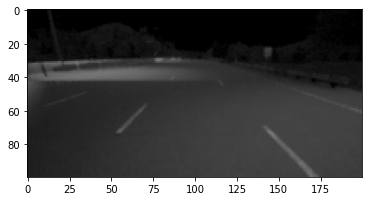

input shape: (100, 200, 1)
input first pixel: [0.]
label: 5e-06


In [9]:
# Beispielbild anzeigen
import matplotlib.pyplot as plt
image = images[0]
label = labels[0]
plt.imshow(cv.cvtColor(image, cv.COLOR_GRAY2RGB))
plt.show()
print("input shape:", image.shape)
print("input first pixel:", image[0, 0])
print("label:", label)

#### Bilder später nachladen

In [5]:
class ImageBatchGenerator(tf.keras.utils.Sequence):
    """
    Zum dynamischen Laden der Bilder während des Trainings
    Dokumentation unter https://keras.io/api/utils/python_utils/#sequence-class
    weitere Hinweise auch unter https://medium.com/datadriveninvestor/keras-training-on-large-datasets-3e9d9dbc09d4
    """
    def __init__(self, x_filenames, y, batch_size):
        self.x_filenames = x_filenames
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x_filenames) / self.batch_size)

    def __getitem__(self, idx):
        # create sublist of filenames and labels for current batch
        batch_x_filenames = self.x_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_x_images = []
        for image_filename in batch_x_filenames:
            filepath = os.path.join(directory, img_subdirectory, image_filename)
            # load image
            image = cv.imread(filepath, cv.IMREAD_UNCHANGED)
            # Matrix um dritte Dimension erweitern
            image = np.expand_dims(image, axis=2)
            # Werte der Bilder normalisieren
            image = image / 255
            # append image to batch list
            batch_x_images.append(image)
            
        return np.array(batch_x_images), np.array(batch_y)

### Aufteilen in Trainings-, Validierungs- und Testdaten

In [5]:
X, X_test, y, y_test = train_test_split(image_filenames, labels, test_size=0.1, random_state=4)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=5)

print("X train shape:", X_train.shape)
print("X val shape:", X_val.shape)
print("X test shape:", X_test.shape)

X train shape: (141883,)
X val shape: (35471,)
X test shape: (19707,)


## Trainieren des CNNs

### Model

In [7]:
model = tf.keras.models.Sequential([
    BatchNormalization(input_shape=(100, 200, 1)),
    Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='elu'),
    Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'),
    Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'),

    Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='elu'),
    Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='elu'),
    
    Flatten(),
    Dense(100, activation='elu'),
    Dropout(0.5),
    Dense(50, activation='elu'),
    Dropout(0.5),
    Dense(10, activation='elu'),
    Dropout(0.5),
    Dense(1, activation='linear')
  ])

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 100, 200, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 98, 24)        624       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 5760)              0

### Trainieren

In [12]:
# Generator erzeugen
batch_size = 64

training_generator = ImageBatchGenerator(X_train, y_train, batch_size)
validation_generator = ImageBatchGenerator(X_val, y_val, batch_size)
test_generator = ImageBatchGenerator(X_test, y_test, batch_size)

In [13]:
#history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=10, validation_split=0.2)
history = model.fit(training_generator, epochs=10, validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2217 steps, validate for 555 steps
Epoch 1/10
2217/2217 [==============================] - 976s 440ms/step - loss: 0.0374 - root_mean_squared_error: 0.1934 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 2/10
2217/2217 [==============================] - 238s 107ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0381
Epoch 3/10
2217/2217 [==============================] - 238s 107ms/step - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 4/10
2217/2217 [==============================] - 244s 110ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 5/10
2217/2217 [==============================] - 222s 100ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 6/10
2217

### Visualisierung

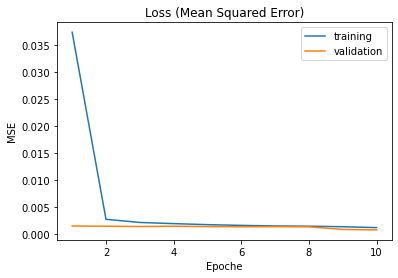

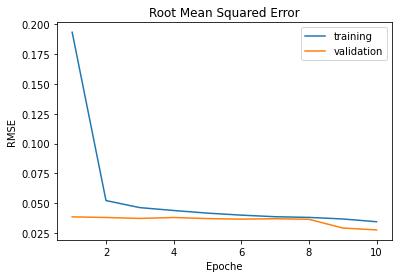

In [14]:
epoch_range = range(1, len(history.history['loss']) + 1)

plt.title('Loss (Mean Squared Error)')
plt.plot(epoch_range, history.history['loss'], label='training')
plt.plot(epoch_range, history.history['val_loss'], label='validation')

plt.xlabel('Epoche')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.title('Root Mean Squared Error')
plt.plot(epoch_range, history.history['root_mean_squared_error'], label='training')
plt.plot(epoch_range, history.history['val_root_mean_squared_error'], label='validation')
plt.xlabel('Epoche')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Evaluieren des Modells

In [16]:
train_mse, train_rmse = model.evaluate(training_generator)
print("Training-RMSE:", train_rmse)
test_mse, test_rmse = model.evaluate(test_generator)
print("Test-RMSE:", test_rmse)

  ...
    to  
  ['...']
2217/2217 [==============================] - 166s 75ms/step - loss: 7.0934e-04 - root_mean_squared_error: 0.0266
Training-RMSE: 0.02662866
  ...
    to  
  ['...']
308/308 [==============================] - 116s 378ms/step - loss: 8.2682e-04 - root_mean_squared_error: 0.0288
Test-RMSE: 0.028756771


## Speichern des Models

In [17]:
model.save("model.h5")

## manueller Test auf einem Testdatenbild

In [6]:
model = tf.keras.models.load_model("model.h5")

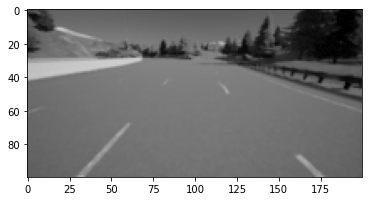

Vorhergesagt: -0.002513 Korrekt: -0.003297 Differenz: -0.000784


In [16]:
index = 1

# Bild laden
filepath = os.path.join(directory, img_subdirectory, X_test[index])
image = cv.imread(filepath, cv.IMREAD_UNCHANGED)

# Bild anzeigen
plt.imshow(cv.cvtColor(image, cv.COLOR_GRAY2RGB))
plt.show()

# Bild vorverarbeiten
image = np.expand_dims(image, axis=2)
image = image / 255

# Vorhersagen treffen
X_manual_test = np.array([image])
y_predict = model.predict(X_manual_test)
y_truth = y_test[index]

# Vergleich anzeigen
print("Vorhergesagt:", f"{y_predict[0,0]:.6f}", "Korrekt:", f"{y_truth:.6f}", "Differenz:", f"{y_truth-y_predict[0,0]:.6f}")